<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Plot-Illgraben-figures" data-toc-modified-id="Plot-Illgraben-figures-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Plot Illgraben figures</a></span></li><li><span><a href="#Plot-USGS-figures" data-toc-modified-id="Plot-USGS-figures-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Plot USGS figures</a></span></li><li><span><a href="#Plot-correlations" data-toc-modified-id="Plot-correlations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot correlations</a></span><ul class="toc-item"><li><span><a href="#USGS" data-toc-modified-id="USGS-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>USGS</a></span></li><li><span><a href="#Illgraben" data-toc-modified-id="Illgraben-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Illgraben</a></span></li></ul></li></ul></div>

In [8]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import obspy
from scipy import signal
import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.lines import Line2D
from obspy.signal.konnoohmachismoothing import konno_ohmachi_smoothing
from process_tilt_data import *
matplotlib.rcParams.update({'font.size': 14})

In [2]:
# Get general information on all tilt events
info = pd.read_csv("../data/00_info_tilt_events.csv")
info.head()

Unnamed: 0  year  julday                 time  max_tilt  tilt0  tilt1  \
0           0  2018     162  2018-06-11T10:38:41       NaN    NaN    NaN   
1           1  2018     163  2018-06-12T19:05:41       NaN    NaN    NaN   
2           2  2018     206  2018-07-25T17:11:10       NaN    NaN    NaN   
3           3  2018     220  2018-08-08T18:02:04       NaN    NaN    NaN   
4           4  2019     161  2019-06-10T18:35:51      0.74   0.74    0.0   

   tilt2   h99   location  ...  total_run_time  daily_precipitation_[mm]  \
0    NaN  3.50  Illgraben  ...               0                       0.0   
1    NaN   NaN  Illgraben  ...               0                       0.0   
2    NaN  2.00  Illgraben  ...               0                       0.0   
3    NaN   NaN  Illgraben  ...               0                       0.0   
4    0.0  0.64  Illgraben  ...               0                       0.0   

   area_under_tilt   start     end  max_forces  surge0  surge1  surge2  \
0              NaN     NaN     NaN         NaN     NaN     NaN     NaN   
1              NaN     NaN     NaN         NaN     NaN     NaN     NaN   
2              NaN     NaN     NaN         NaN     NaN     NaN     NaN   
3              NaN     NaN     NaN         NaN     NaN     NaN     NaN   
4            591.0  3582.0  6488.0    89.96848     0.0     0.0     0.0   

   max_slope  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4   0.015344  

[5 rows x 24 columns]

# Plot Illgraben figures

In [5]:
# Get information from info file
loc = "Illgraben" # Set location
df = info[info['location'] == loc].copy().reset_index() 

In [16]:
"""
Get data for figure 2 in paper
"""
# Get raw data and inventory
t = obspy.UTCDateTime(df.time[14])
st_all = obspy.read(f'../data/illgraben_seismic_data/raw_data/2020/ILL11/H*/*{t.julday}')
print(t)

# Preprocess data
st = st_all.copy()
st.trim(t- 0.5 * 3600, t + 2.5 * 3600)
st.detrend('demean')
st.taper(0.05)
st.merge(fill_value='interpolate')
inv = obspy.read_inventory('../data/illgraben_seismic_data/response/ILL11_inventory.xml')   
st.remove_sensitivity(inv)
for tr in st:
    tr.data *= 1e9
    
# Get raw data from noise window before the event (for comparision)
st_noise = st_all.copy()
st_noise.trim(t - 3.5 * 3600, t- 0.5 * 3600)
st_noise.detrend('demean')
st_noise.taper(0.05)
st_noise.merge(fill_value='interpolate')
st_noise.remove_sensitivity(inv)

2020-06-04T15:42:22.000000Z


3 Trace(s) in Stream:
XP.ILL11..HHE | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHN | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHZ | 2020-06-04T12:12:22.000000Z - 2020-06-04T15:12:22.000000Z | 100.0 Hz, 1080001 samples

In [17]:
# Get smooth spectrum for the period during the event and before 

st1 = st.copy().resample(2)

freqs = {}
konno_specs = {}
freqs_noise = {}
konno_specs_noise = {}
for tr in st1:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr.stats.sampling_rate)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs[tr.stats.channel] = freq
    konno_specs[tr.stats.channel] = new_spectra
    
st1_noise = st_noise.copy().resample(2)
for tr in st1_noise:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr.stats.sampling_rate ,color = co,linewidth=0.7)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs_noise[tr.stats.channel] = freq
    konno_specs_noise[tr.stats.channel] = new_spectra



<IPython.core.display.Javascript object>


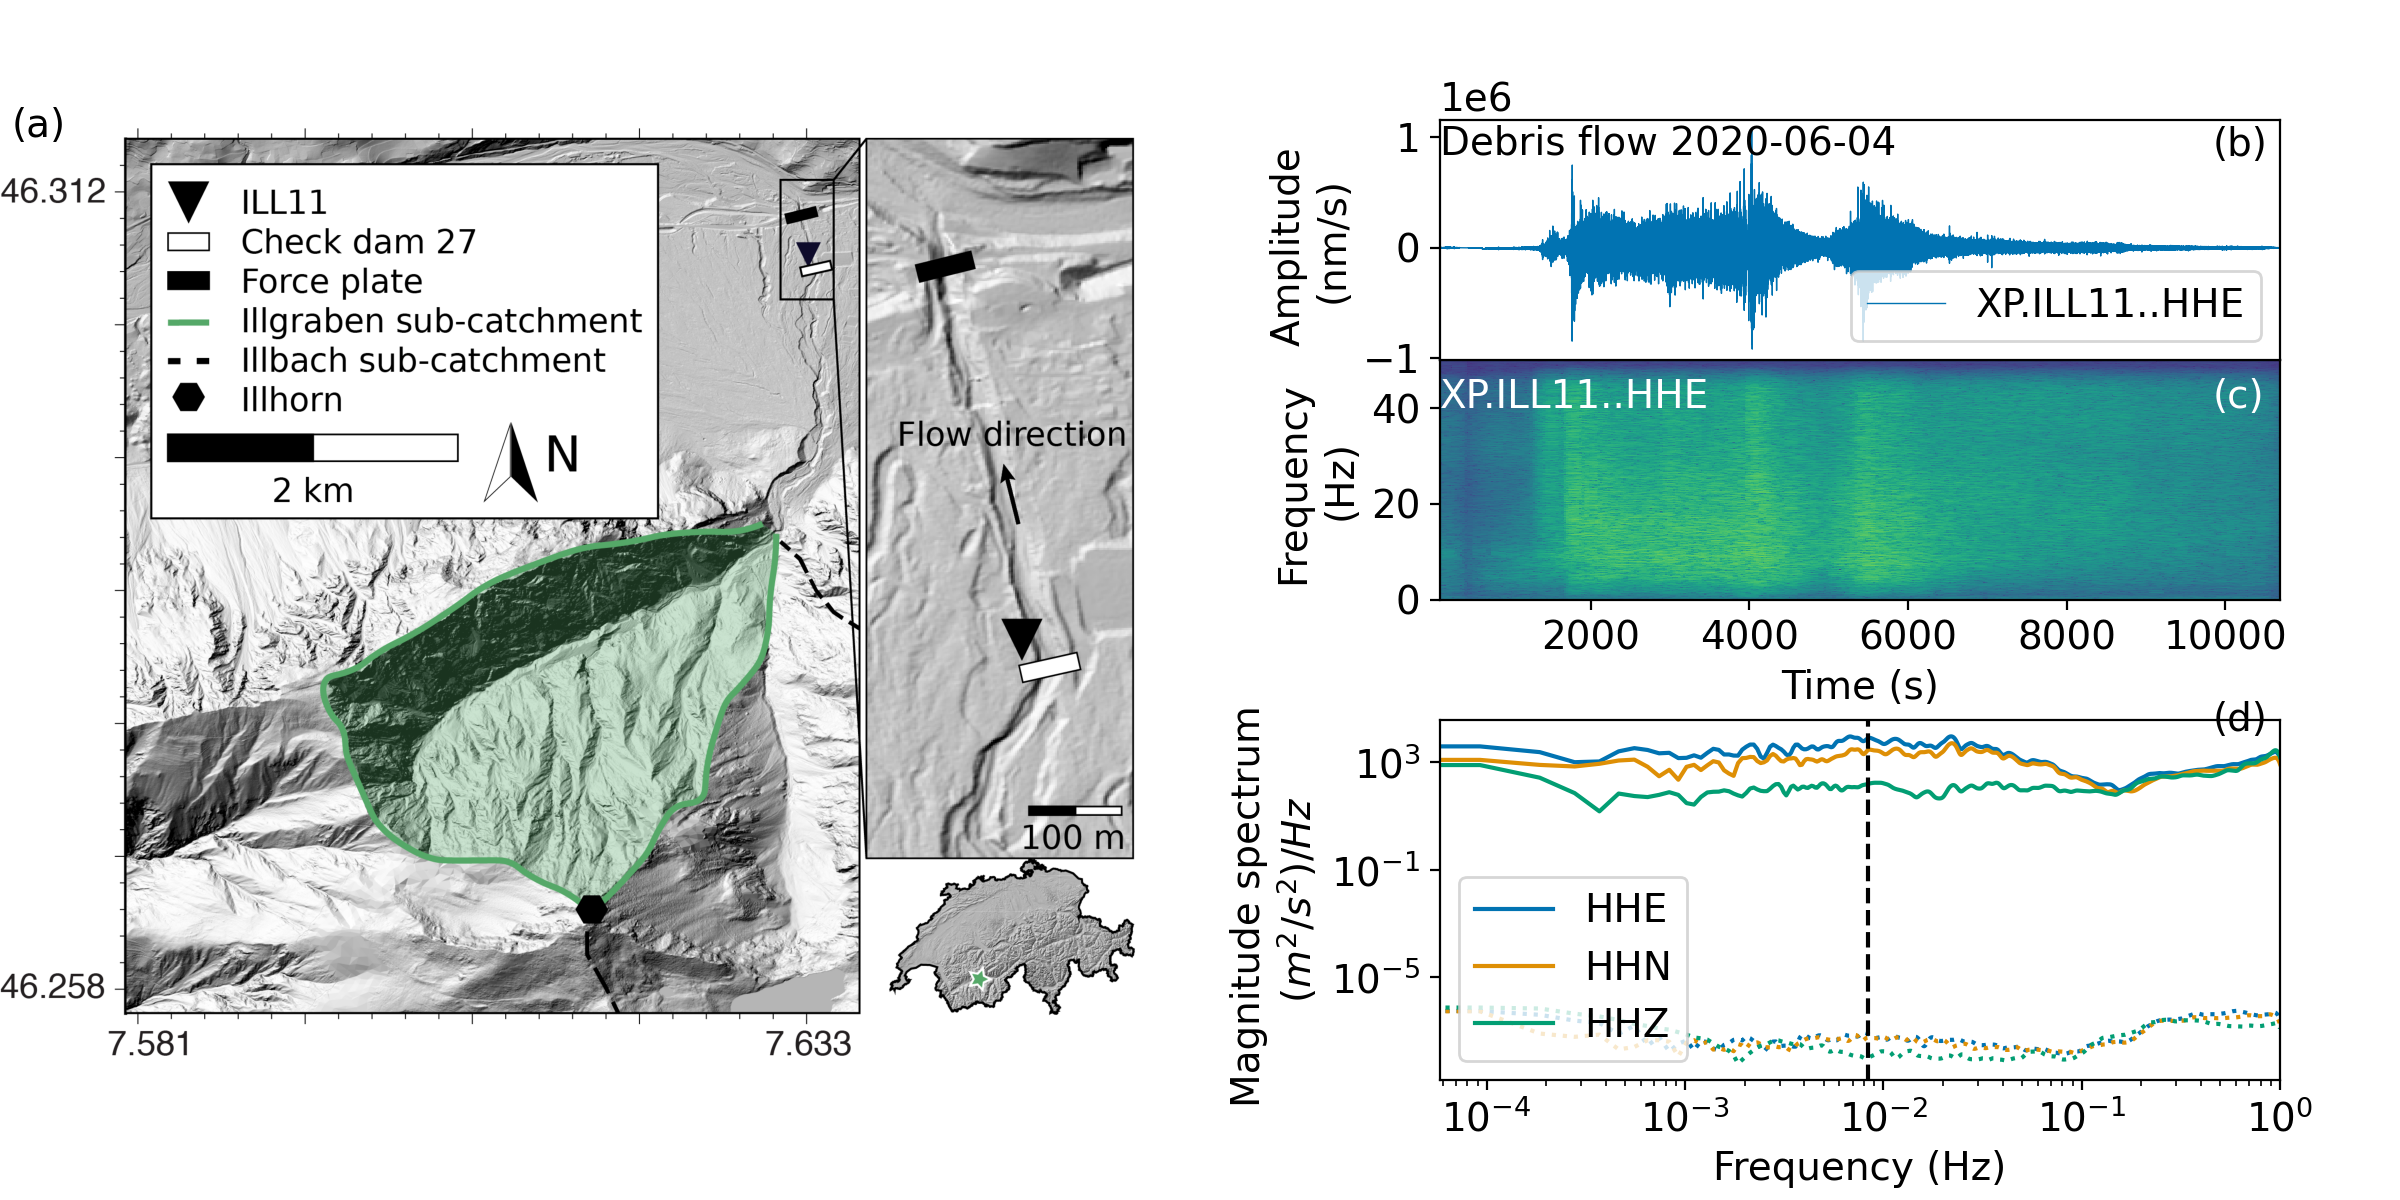

/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


[]

In [18]:
# Plot figure 2 in paper
from matplotlib import colors

fig = plt.figure(figsize = (12, 6))
    # [left bottom width height] 
axbigger = fig.add_axes([0.0, 0.1, 0.5, 0.8]) # Map
axbig = fig.add_axes([0.6, 0.1, 0.35, 0.3]) # Spectrum
ax4 = fig.add_axes([0.6, 0.5, 0.35, 0.2]) # Waveform
ax3 = fig.add_axes([0.6, 0.7, 0.35, 0.2]) # Spectrogram

#fac = 0.3
#i = 0
#j = 0

ns= 20 * 1024 # Number of samples per window to compute spectrogram
colors1 = sns.color_palette('colorblind', 3) # Define colors

# Load Illgraben map
img = mpimg.imread('../figs/map_illgraben.png')
axbigger.imshow(img)
axbigger.axis('off')

# Plot raw seismic data
for tr, co in zip(st[::-1],colors1[::-1]):
    if tr.stats.channel == 'HHE':
        ax3.plot(tr.times(), tr.data, color = co, label=tr.id, linewidth=0.5) # Plot signal
        f, t, Sxx = signal.spectrogram(tr.data, 100, nperseg=ns, noverlap = 0.9*ns, scaling='density') # Compute spectorgram
        ax4.pcolormesh(t, f, Sxx, norm=colors.PowerNorm(gamma=0.05), shading='auto', cmap='viridis', rasterized=True) # Plot spectrogram
        ax4.set_ylabel('Frequency \n(Hz)')

# Plot spectra
for key, co in zip(konno_specs,colors1):
    axbig.loglog(freqs[key], konno_specs[key], color=co, label=key)
for key, co in zip(konno_specs_noise,colors1):
    axbig.loglog(freqs[key], konno_specs_noise[key], linestyle = ":", color=co)
    
# Clean up axis
axbig.set_ylabel('Magnitude spectrum \n$(m^2/s^2)/Hz$')
axbig.set_xlabel('Frequency (Hz)')
axbig.axvline(1/120, color="k", linestyle="--")

axbig.set_xlim(freqs[key][0], 1)
axbig.legend(loc="lower left")
ax4.set_xlim(t[0], t[-1])   
ax3.set_xlim(t[0], t[-1])   
ax3.legend(loc='lower right')

ax3.set_ylabel("Amplitude \n(nm/s)")
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

ax3.text(100, 0.8* max(tr.data), f"Debris flow {tr.stats.starttime.date}")
ax4.text(100, 40, 'XP.ILL11..HHE', color='white')
ax4.set_xlabel("Time (s)")

# Annotate text
annot = ['(a)','(b)', '(c)', '(d)']
axes = (axbigger,ax3, ax4, axbig)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(d)':
        ax.text(xlim[0] + 0.46*(xlim[1] - xlim[0]), ylim[1] - 0.6*(ylim[1] - ylim[0]), an)
    if an == '(a)':
        ax.text(xlim[0] + 0.01*(xlim[1] - xlim[0]), ylim[1] - 0.01*(ylim[1] - ylim[0]), an, color='black')
    elif an == '(b)':
        ax.text(xlim[0] + 0.92*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an)
    elif an == '(c)':
        ax.text(xlim[0] + 0.92*(xlim[1] - xlim[0]), ylim[1] - 0.2*(ylim[1] - ylim[0]), an, color='white')
        

ax3.xaxis.set_ticks([])
axbigger.yaxis.set_ticks([])
axbigger.xaxis.set_ticks([])



In [19]:
"""
Get data for figure 5 in paper
"""
sigs = obspy.read('../data/illgraben_seismic_data/trimmed_data/*_signal.mseed')
tilts = obspy.read('../data/illgraben_tilt_data/*.mseed')
sigs = sigs.select(channel="*E") 

# Remove outliers with noise
tilts.remove(tilts[5]) # Remove July 3, 2019 event with low amplitudes (flood?) and without force plate data
sigs.remove(sigs[5])
tilts.remove(tilts[6]) # Remove July 26, 2019 event with overlapping long-period noise
sigs.remove(sigs[6])
tilts.remove(tilts[6]) # Remove August 11, 2019 event with overlapping long-period noise
sigs.remove(sigs[6])
tilts.remove(tilts[10]) # Remove June 9, 2020 event with low amplitudes (flood?) and without force plate data
sigs.remove(sigs[10])

14 Trace(s) in Stream:
XP.ILL11..BHE | 2019-06-10T17:35:50.995000Z - 2019-06-10T20:35:50.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-06-10T22:12:51.995000Z - 2019-06-11T01:12:51.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-06-21T18:45:06.995000Z - 2019-06-21T21:45:06.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-01T22:30:30.995000Z - 2019-07-02T01:30:30.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-02T21:47:13.995000Z - 2019-07-03T00:47:13.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-07-15T03:22:57.995000Z - 2019-07-15T06:22:57.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..BHE | 2019-08-20T16:10:13.995000Z - 2019-08-20T19:10:13.995000Z | 50.0 Hz, 540001 samples
XP.ILL11..HHE | 2020-06-04T14:42:22.000000Z - 2020-06-04T17:42:22.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHE | 2020-06-07T08:27:19.000000Z - 2020-06-07T11:27:19.000000Z | 100.0 Hz, 1080001 samples
XP.ILL11..HHE | 2020-06-08T16:57:53.000000Z - 2020-06-08T19:57:53.000000Z

<IPython.core.display.Javascript object>


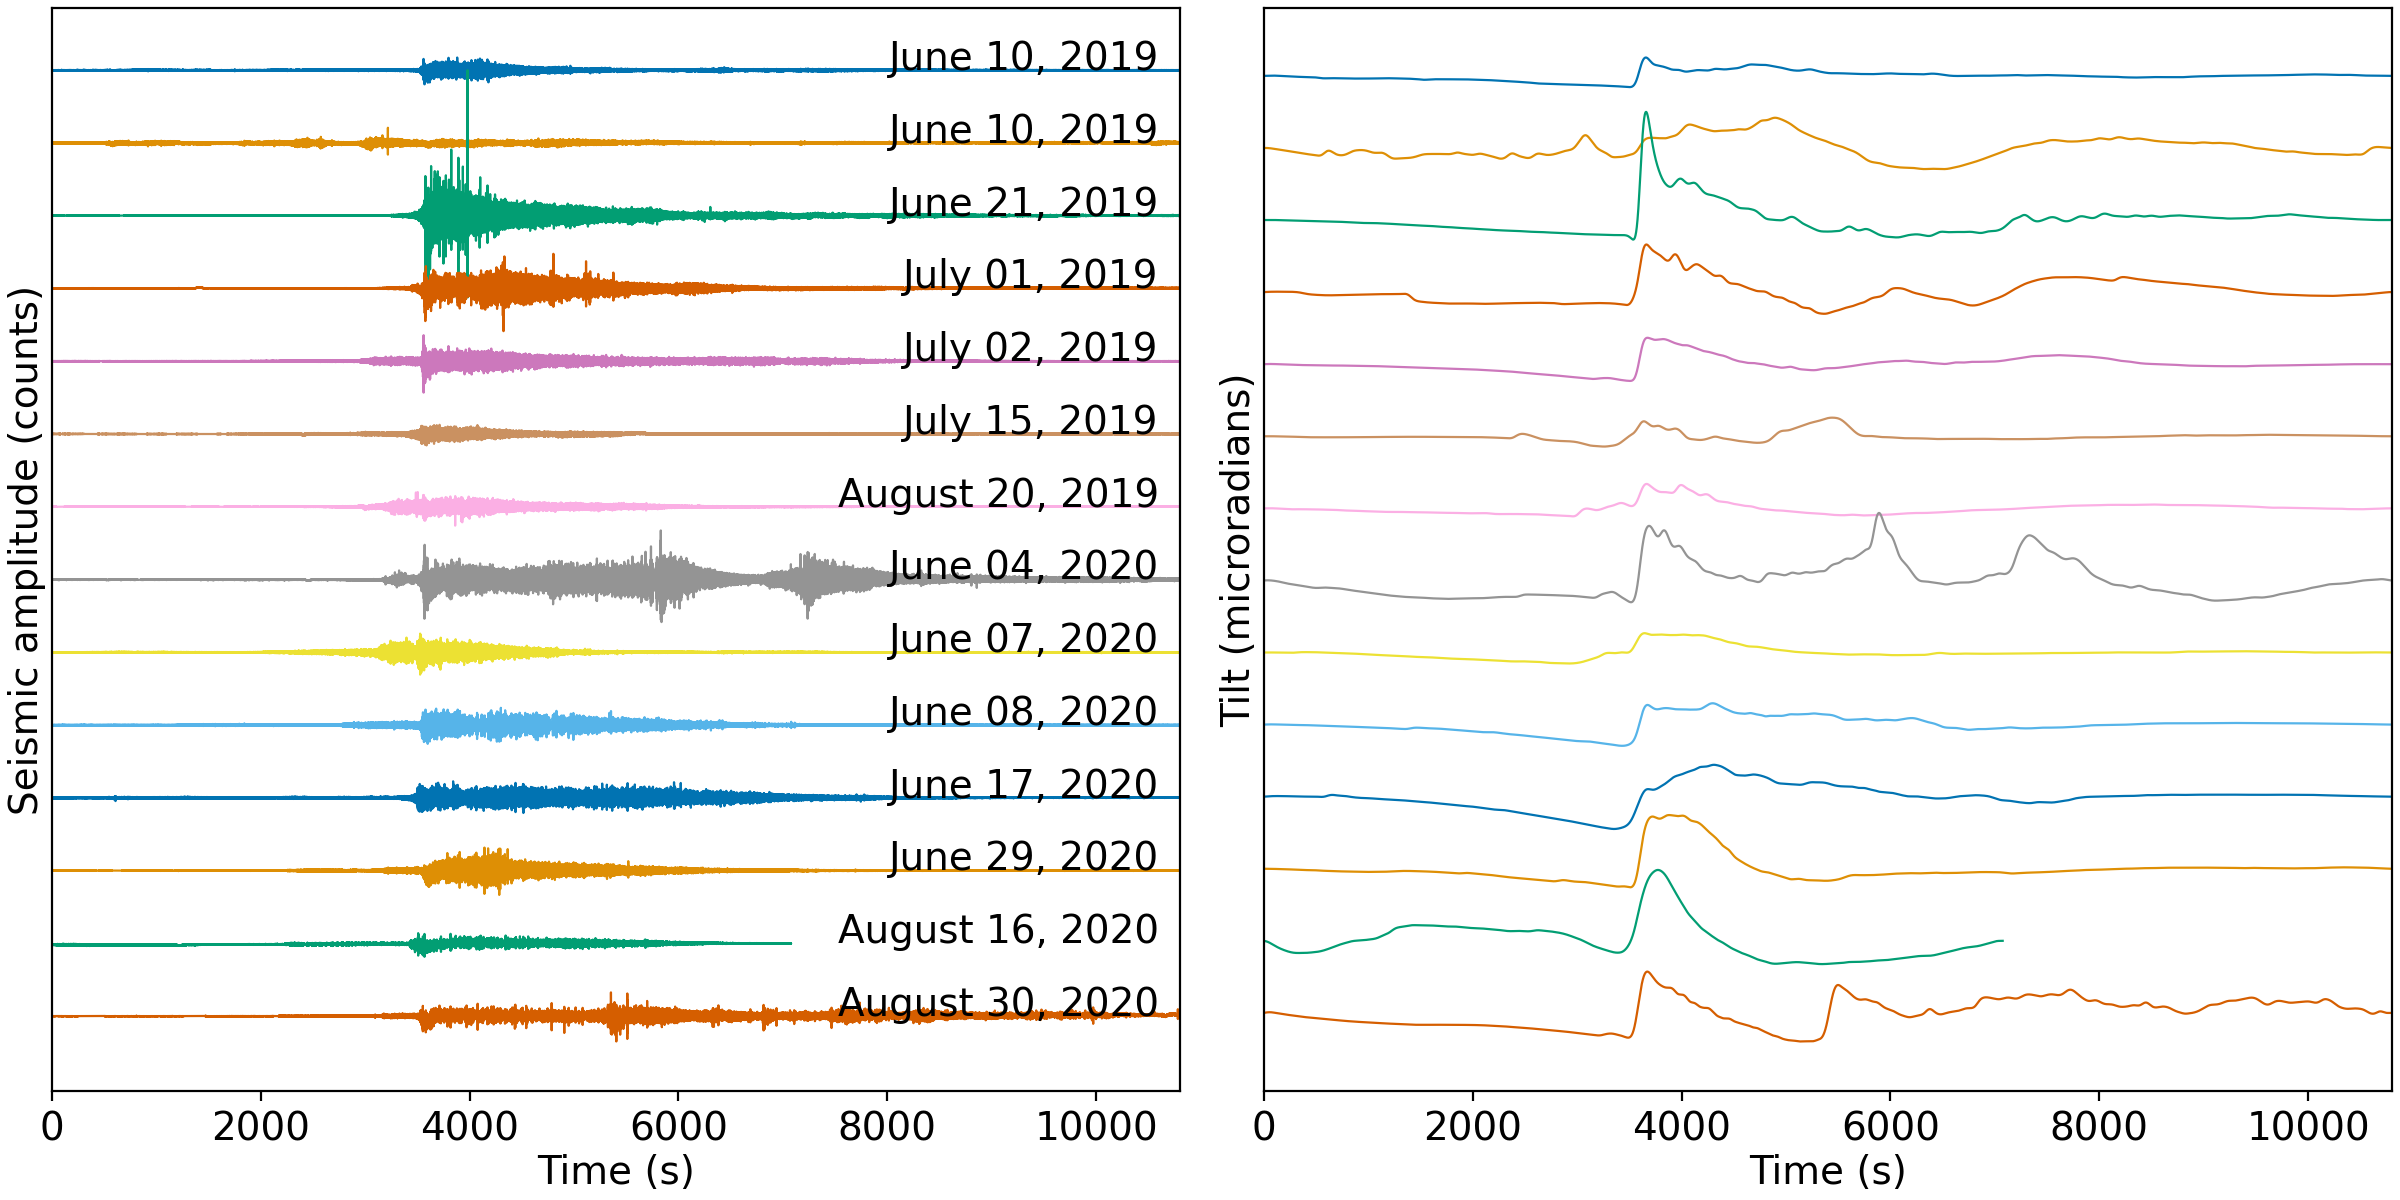

[]

In [20]:
fig = plt.figure(constrained_layout=True, figsize=(12, 6))
axs = fig.subfigures(1, 2)

maxsig = np.max([np.max(tr.data) for tr in sigs]) # Get maximum amplitudes from signals
maxtilt = np.max([np.max(tr.data) for tr in tilts])

fac = 0.5 # Define factor to change spacing between events
fact = 0.15
i = 0
j = 0

ax2 = axs[0].subplots(1,1)
ax3 = axs[1].subplots(1,1)

colors2 = sns.color_palette('colorblind', len(sigs))
for tr1, sig1, co in zip(tilts, sigs, colors2):  
    ax3.plot(tr1.times(), 1.5*fact*tr1.copy().data-i, color = co, label=f"{tr1.stats.starttime.date.strftime('%d %B, %Y')}", linewidth=0.8)
    ax2.plot(sig1.times(), sig1.copy().data-j, color = co, label=f"{tr1.stats.starttime.date.strftime('%d %B, %Y')}", linewidth=0.8)
    ax2.text(10600, -j, sig1.stats.starttime.date.strftime('%B %d, %Y'), ha='right')
    i += fact*maxtilt
    j += fac*maxsig

ax2.set_xlim(0, 10800)
ax3.set_xlim(0, 10800)
ax2.yaxis.set_ticks([])
ax2.set_ylabel('Seismic amplitude (counts)')
ax3.set_ylabel('Tilt (microradians)')
ax2.set_xlabel('Time (s)')
ax3.set_xlabel('Time (s)')
ax3.yaxis.set_ticks([])

# Plot USGS figures

In [3]:
# Get information from info file
loc = "USGS" # Set location
df = info[info['location'] == loc].copy().reset_index() 
times = list(df['time'])
print(times)

['2016-06-14T21:53:58', '2016-06-15T21:47:29', '2016-06-16T22:26:26', '2016-06-21T18:57:21', '2016-06-22T19:10:54', '2016-06-23T14:52:50']


In [4]:
"""
Get data for figure 1 in paper
"""
# Get tiltmeter data
tm = obspy.read('../data/USGS_tiltmeter_data/3662*')
tme = process_tilt_data(tm, 40, 60)

# Get raw seismic data to plot event
t = obspy.UTCDateTime(times[4])
st = obspy.read(f'../data/USGS_seismic_data/ZK/E02/*{t.julday}')
inv = obspy.read_inventory('../data/USGS_seismic_data/response/usgs_E02_2016.xml')
st.remove_sensitivity(inv)
for tr in st:
    tr.data *= 1e9
    
st.trim(t-20, t + 60)



3 Trace(s) in Stream:
ZK.E02..CH1 | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples
ZK.E02..CH2 | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples
ZK.E02..CHZ | 2016-06-22T19:10:34.000000Z - 2016-06-22T19:11:54.000000Z | 500.0 Hz, 40001 samples

<IPython.core.display.Javascript object>


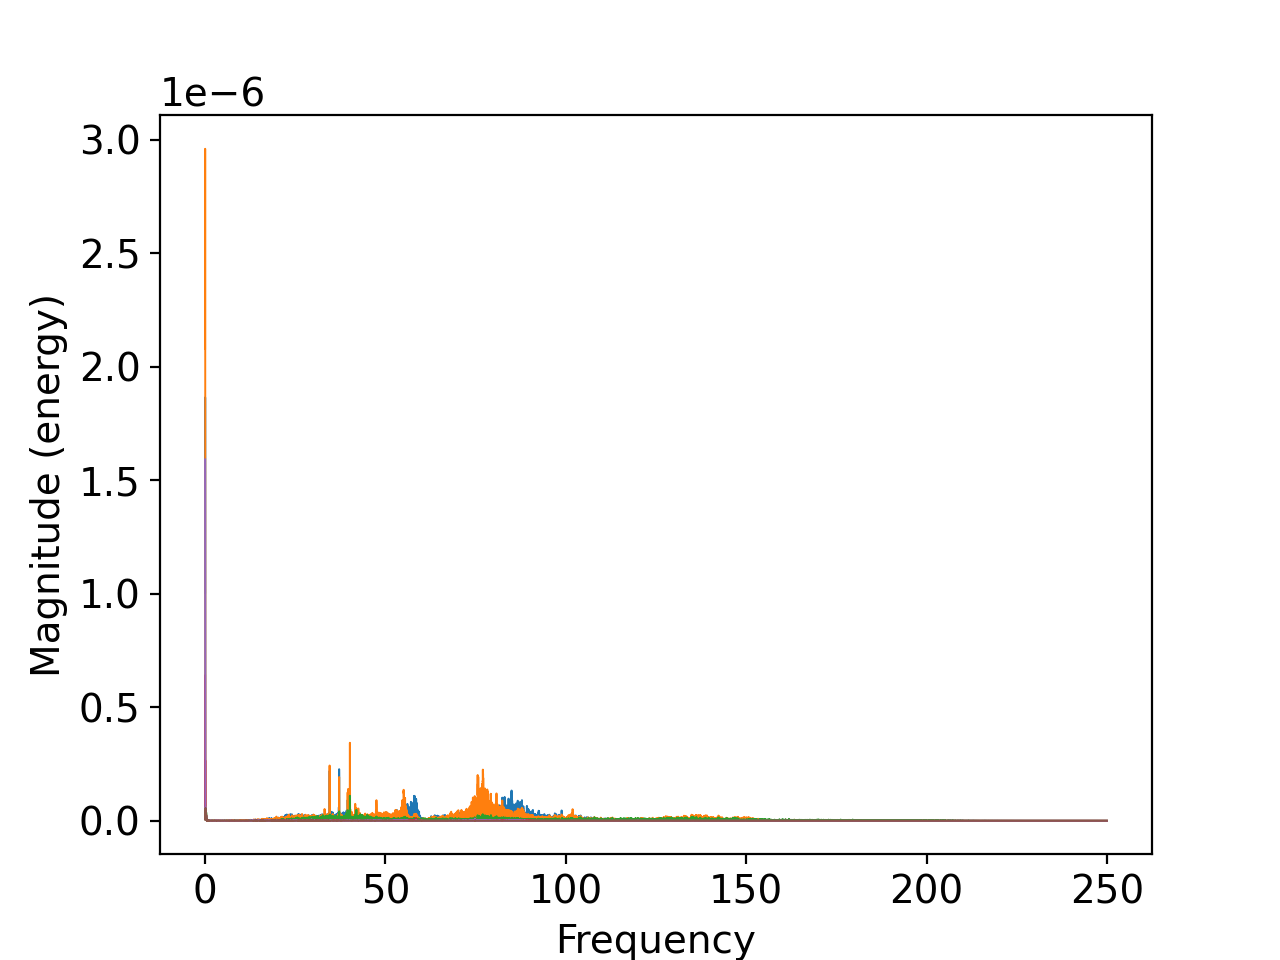

In [9]:
# Get smoothed spectrum
# Get noise
t = obspy.UTCDateTime(times[4])
st_full = obspy.read(f'../data/USGS_seismic_data/ZK/E02/*{t.julday}')
st_full.remove_sensitivity(inv)
#for tr in st:
#    tr.data *= 1e9
st_full.detrend("demean")
st_full.taper(0.01)
#st.filter("bandpass", freqmin=1/120, freqmax=100)
st_sig = st_full.copy().trim(t + 2, t + 52)   
st_noise = st_full.copy().trim(t-110, t - 60)

# Apply konno_ohmachi_smoothing

freqs = {}
konno_specs = {}
freqs_noise = {}
konno_specs_noise = {}
for tr in st_sig:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr.stats.sampling_rate,linewidth=0.7)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs[tr.stats.channel] = freq
    konno_specs[tr.stats.channel] = new_spectra
for tr in st_noise:
    spectra, freq, _ = plt.magnitude_spectrum(tr.data,tr.stats.sampling_rate,linewidth=0.7)
    new_spectra = konno_ohmachi_smoothing(spectra, freq, bandwidth=60, normalize=False)
    freqs_noise[tr.stats.channel] = freq
    konno_specs_noise[tr.stats.channel] = new_spectra

<IPython.core.display.Javascript object>


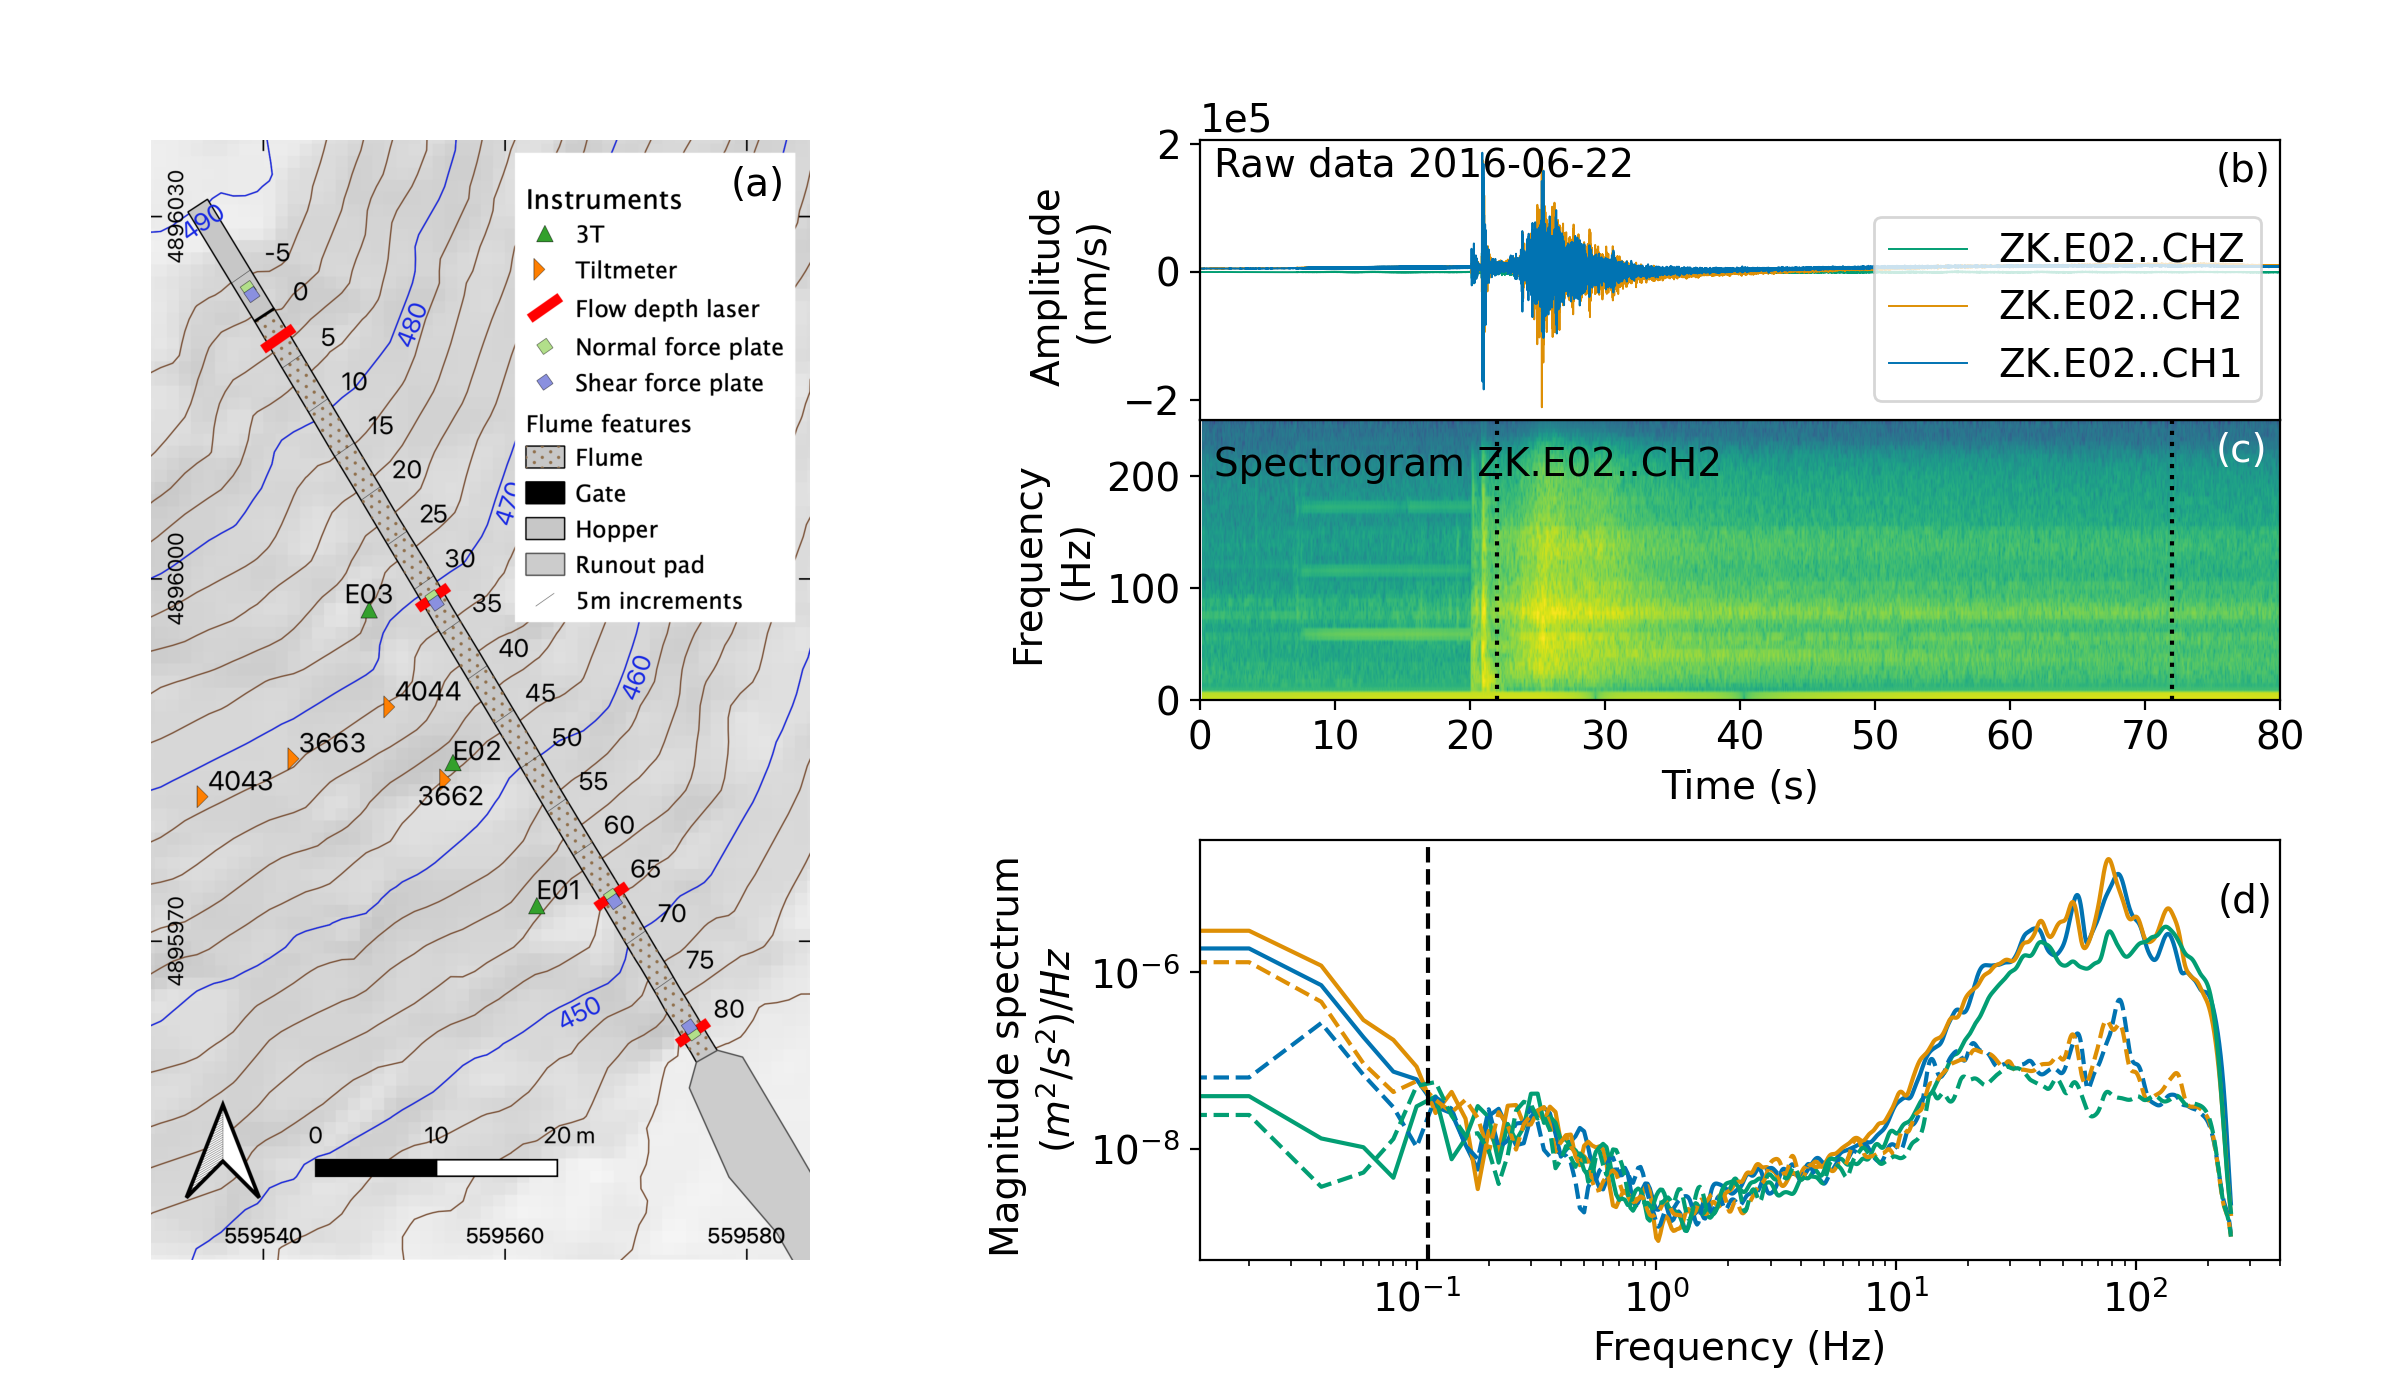

In [12]:
"""
Plot figure 1 in paper
"""
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
img = mpimg.imread('../figs/map_usgs.png')



# Set up figure outline
fig = plt.figure(figsize = (12, 7))
    # [left bottom width height] 
axbigger = fig.add_axes([0.0, 0.1, 0.4, 0.8]) # Map
axbig = fig.add_axes([0.5, 0.1, 0.45, 0.3]) # Spectrum
ax3 = fig.add_axes([0.5, 0.5, 0.45, 0.2]) # Waveform
ax4 = fig.add_axes([0.5, 0.7, 0.45, 0.2]) # Spectrogram
colors = sns.color_palette('colorblind', 3)


axbigger.imshow(img)
#ax0.set_title('2016 experiment setup')
axbigger.axis('off')
ax3.specgram(st[1].data, NFFT=130, Fs=st[1].stats.sampling_rate,  scale='dB', rasterized=True)
for tr, co in zip(st[::-1], colors[::-1]):
    ax4.plot(tr.times(), tr, color = co, label=tr.id, linewidth=0.7)
for channel,co in zip(freqs,colors):
    axbig.loglog(freqs[channel], konno_specs[channel], color=co, label=channel)
for channel,co in zip(freqs_noise,colors):
    axbig.loglog(freqs_noise[channel], konno_specs_noise[channel], color=co, linestyle="--", label=channel)
axbig.axvline(1/9, color='k', linestyle='--')
#axbig.axvline(1/120, color='k', linestyle=':')
  
#axbig.axvspan(1/15, 1/9, alpha=0.1, color='grey')
ax4.legend(loc='lower right', fontsize=14)
ax4.set_ylabel('Amplitude \n(nm/s)')
ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax4.text(1, 0.8* max(tr.data), f'Raw data {tr.stats.starttime.date}')
ax4.set_xlim(0, 80)
ax3.text(1, 200, f'Spectrogram {st[1].id}')
ax3.set_ylabel('Frequency \n(Hz)')
axbig.set_ylabel('Magnitude spectrum \n$(m^2/s^2)/Hz$')
ax3.axvline(22, color='k', linestyle=':')
ax3.axvline(72, color='k', linestyle=':')



ax3.set_xlim(0, 80)
axbig.set_xlabel('Frequency (Hz)')

ax3.set_xlabel("Time (s)")

ax4.get_xaxis().set_ticks([])

annot = ['(a)','(b)', '(c)', '(d)']
axes = (axbigger, ax4, ax3, axbig)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(d)':
        ax.text(xlim[0] + 0.55*(xlim[1] - xlim[0]), ylim[1] - 0.85*(ylim[1] - ylim[0]), an)
    elif an == '(a)':
        ax.text(xlim[0] + 0.88*(xlim[1] - xlim[0]), ylim[1] - 0.05*(ylim[1] - ylim[0]), an, color='black')
    elif an == '(b)':
        ax.text(xlim[0] + 0.94*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an)
    elif an == '(c)':
        ax.text(xlim[0] + 0.94*(xlim[1] - xlim[0]), ylim[1] - 0.15*(ylim[1] - ylim[0]), an, color='white')




In [13]:
"""
Get data for figure 4 in paper
"""


# Get tiltmeter data for June 22, 2016 event
ttms = obspy.core.stream.Stream()
tiltmeters = ["4044", "3662"]
t = obspy.UTCDateTime(times[-2])
for stat in tiltmeters:
    tms = obspy.read(f'../data/USGS_tiltmeter_data/event20160622/{stat}.BH*')
    tms.trim(t - 20, t + 60)
    ttms += process_tilt_data(tms, 20, 60)
    
# Get seimic data
stations = ["E01", "E02", "E03"]
seis = obspy.core.stream.Stream()
tseis = obspy.core.stream.Stream()

for stat in stations:
    seis = obspy.read(f'../data/USGS_seismic_data/ZK/{stat}/ZK.{stat}....2016.{t.julday}')
    seis.trim(t - 20, t +60)
    inv = obspy.read_inventory(f'../data/USGS_seismic_data/response/usgs_{stat}_2016.xml')  
    tseis += tilt_above_fc(seis, inv)
    
# Get all tiltmeter data
tm = obspy.read('../data/USGS_tiltmeter_data/3662*')
strot = process_tilt_data(tm, 40, 60)

# Get all tilts from seismic data
tilts = obspy.read('../data/USGS_tilt_data/*E02*')
sigs = obspy.read('../data/USGS_seismic_data/trimmed_data/*')

sigs1 = obspy.read('../data/USGS_seismic_data/trimmed_data/*E03*')
sigs2 = obspy.read('../data/USGS_seismic_data/trimmed_data/*E02*')
sigs3 = obspy.read('../data/USGS_seismic_data/trimmed_data/*E01*')

# Define distances of stations along flume
dis = {"E01": 64, "E02": 49, "E03":31,"4044":40, "3662":49}

<IPython.core.display.Javascript object>


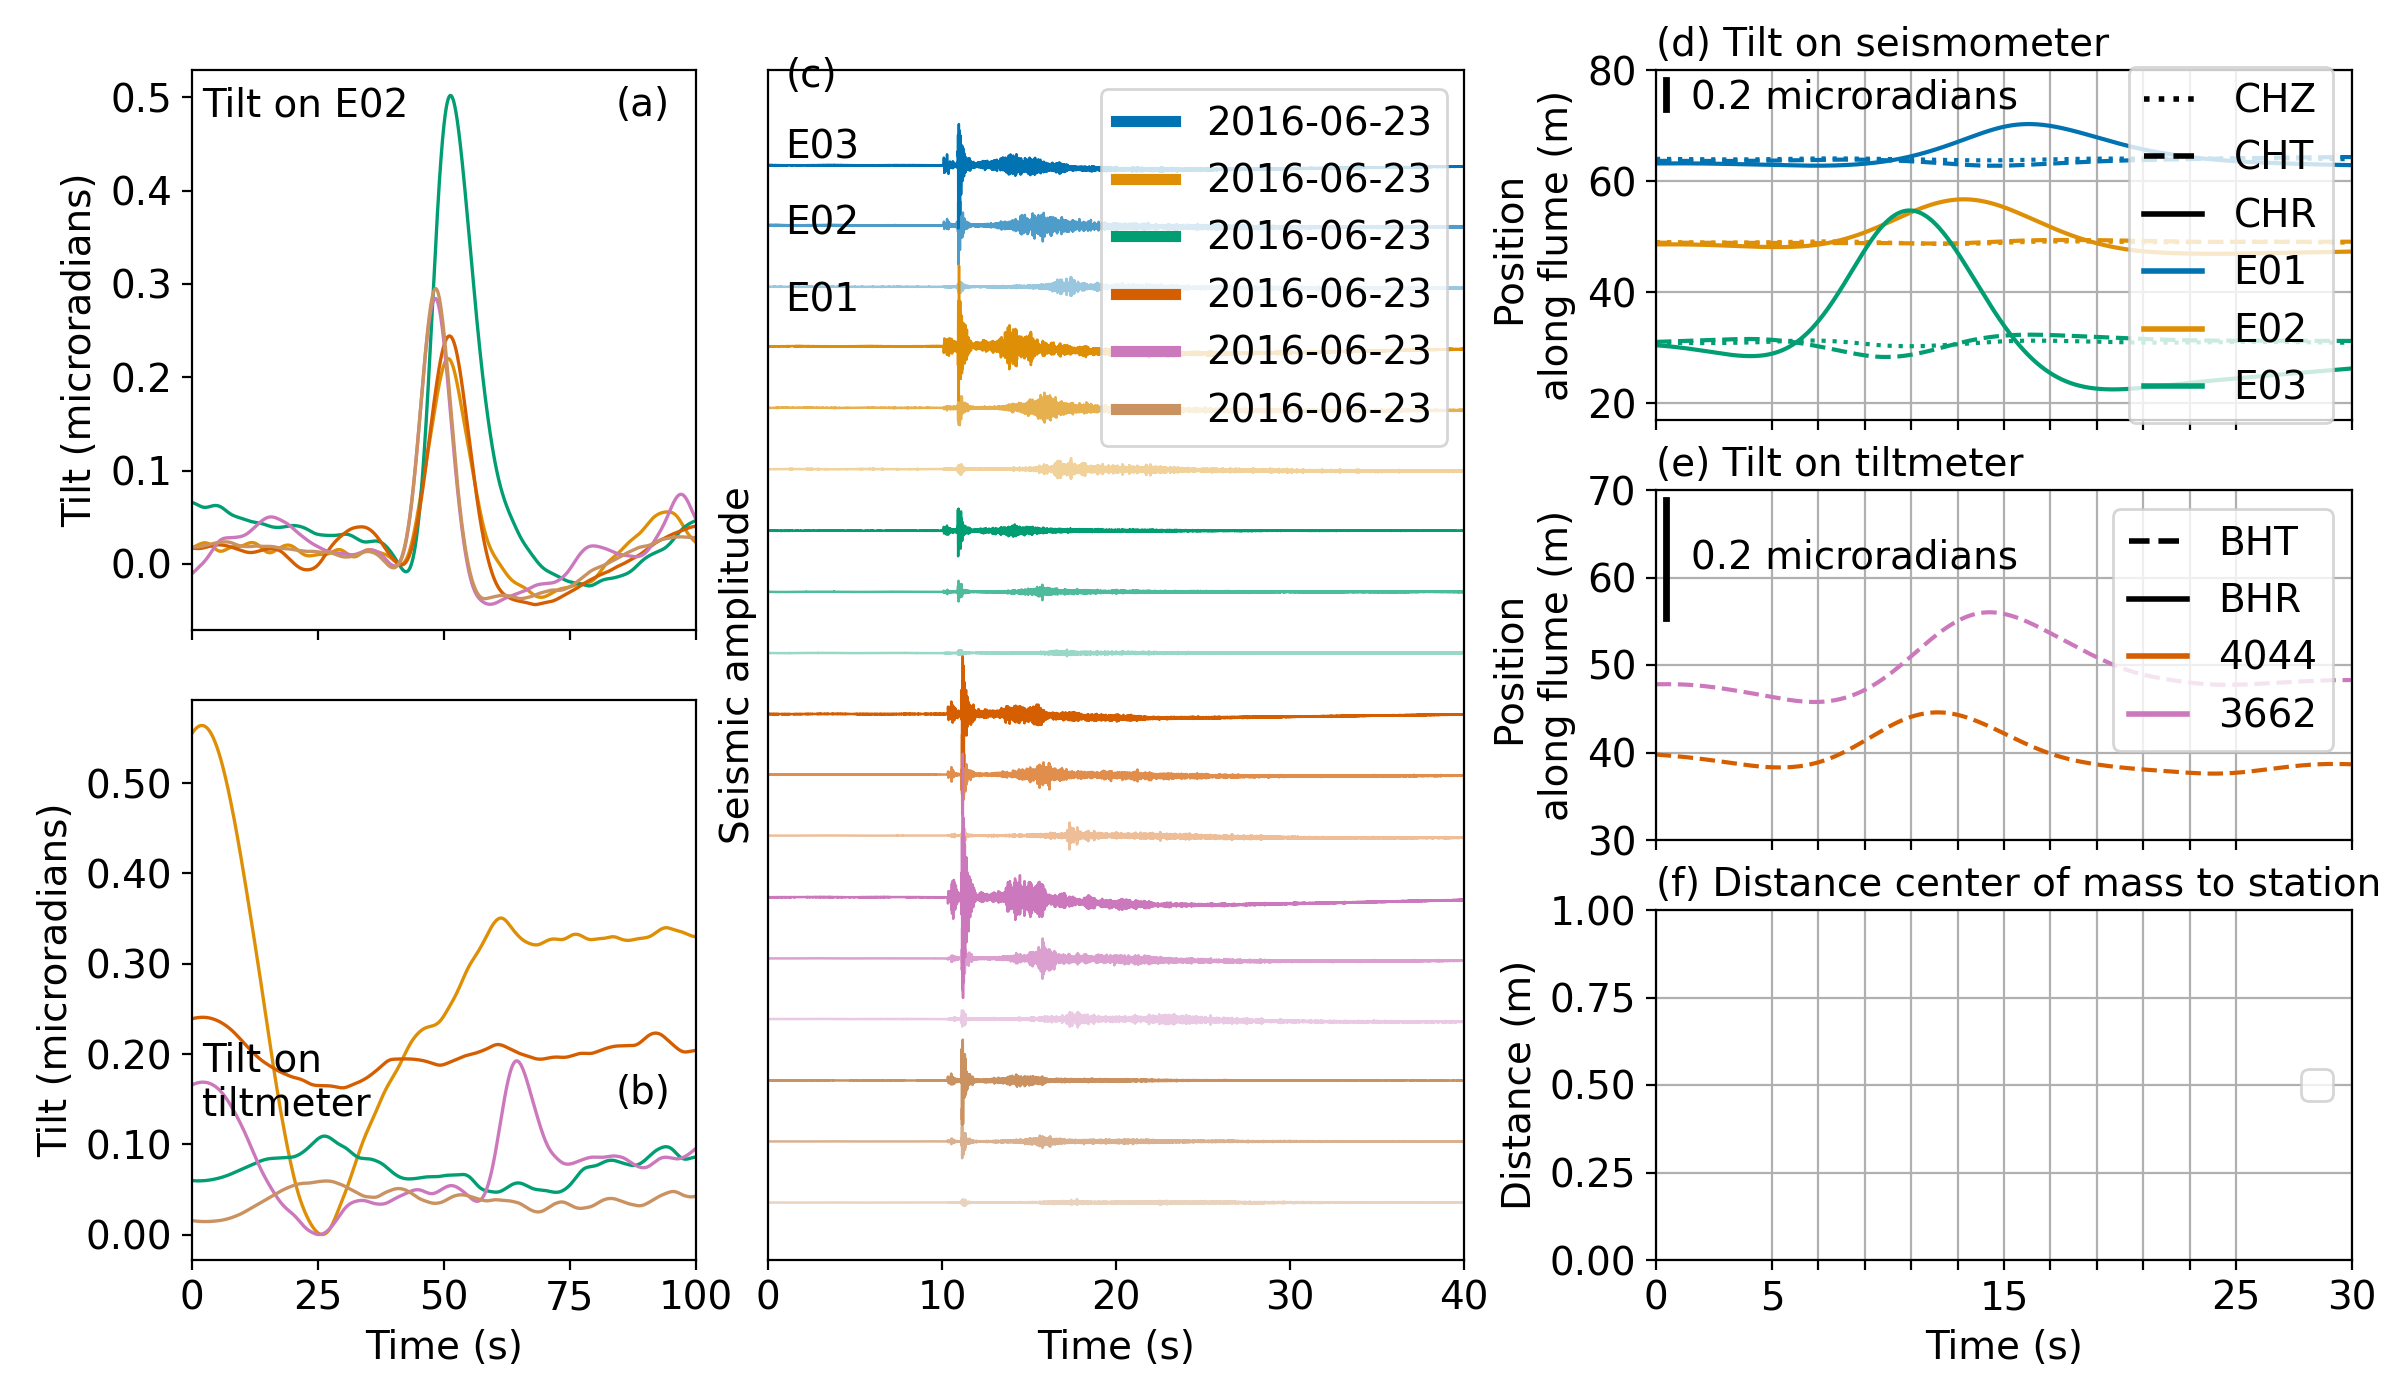

No handles with labels found to put in legend.


Text(0.69, 0.36, '(f) Distance center of mass to station')

In [14]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.image as mpimga
from matplotlib.ticker import FormatStrFormatter

# Set up figure outline
fig = plt.figure(figsize = (12, 7))
    # [left bottom width height] 
ax1 = fig.add_axes([0.08, 0.55, 0.21, 0.4]) # Tilt from seismometer
ax2 = fig.add_axes([0.08, 0.1, 0.21, 0.4]) # Tilt from tiltmeter
ax3 = fig.add_axes([0.32, 0.1, 0.29, 0.85]) # Seismic data of all events on all stations
ax4 = fig.add_axes([0.69, 0.7, 0.29, 0.25]) # Tilt of one event on seismomter
ax5 = fig.add_axes([0.69, 0.4, 0.29, 0.25]) # Tilt of one event on tiltmeter
ax6 = fig.add_axes([0.69, 0.1, 0.29, 0.25]) # Center of mass plot (empty here)


colors = sns.color_palette('colorblind', 6)
maxsig = np.max([np.max(tr.data) for tr in sigs])
maxtilt = np.max([np.max(tr.data) for tr in tilts])
i = 0
j = 0
fac = 0.4
fact = 0.4

for tr1, tr2, co in zip(tilts[1:], strot, colors[1:]):
    tr1s = tr1.copy().slice(tr1.stats.starttime + 60, tr1.stats.starttime + 160)
    ax1.plot(tr1s.times(), tr1s.data-tr1s.data[int(tr1s.stats.sampling_rate*41)], color = co,label=tr1.stats.starttime.date, linewidth=1.2)
    ax2.plot(tr2.times(), tr2.data-np.min(tr2.data), color = co, linewidth=1.2)


ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.text(84, 0.48, '(a)')
ax2.text(84, 0.145,'(b)')
ax1.set_ylabel('Tilt (microradians)')
ax2.set_ylabel('Tilt (microradians)')
ax1.set_xticklabels([])
ax1.set_xlim(0, 100)
ax2.set_xlabel('Time (s)')
ax2.set_xlim(0, 100)
n = 0
for sig1, sig2, sig3, co in zip(sigs1, sigs2, sigs3, colors): 
    ax3.plot(sig1.times()-90, sig1.copy().data-j, color = co, label=f"{tr1.stats.starttime.date}", linewidth=0.9)
    j += fac*maxsig
    ax3.plot(sig2.times()-90, sig2.copy().data-j,alpha=0.7, color = co, linewidth=0.9)   
    j += fac*maxsig   
    ax3.plot(sig3.times()-90, sig3.copy().data-j, alpha=0.4,color = co, linewidth=0.9)
    j += fac*maxsig
    n += 1

ax3.set_xlim(0, 40)

ax3.yaxis.set_ticks([])
ax3.set_ylabel('Seismic amplitude')

ax3.set_xlabel('Time (s)')

leg = ax3.legend(loc='upper left', bbox_to_anchor=(0.45, 1.0), handlelength=1.5)

for line in leg.get_lines():
    line.set_linewidth(4.0)
ax3.text(1, 3e4, 'E03', fontsize=14) #bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 1})
ax3.text(1, -3.4e5, 'E02', fontsize=14)
ax3.text(1, -7.1e5, 'E01', fontsize=14)



ax3.text(1, 3.7e5, '(c)')



### Last 3 subplots

colors = sns.color_palette('colorblind', 5)
lins = [":", "-","--"]

for stat,co in zip(stations, colors):
    offset = dis[stat]
    for tr,ls in zip(tseis.select(station=stat),lins):
        ax4.plot(tr.times(),30*tr.data+offset, color=co, linestyle = ls, label=tr.id)

ax4.set_xlim(15,45)

ax4.set_xticks(ticks=[15, 20, 22,24,26,28,30,32,34,36,38,40,45])
ax4.set_xticklabels([])
ax4.set_ylabel("Position \nalong flume (m)")
ax4.grid(True)

# Make custom legend
legend_elements = [Line2D([0], [0], color='k', linestyle = ":", lw=2,  label='CHZ'),
                   Line2D([0], [0], color='k', linestyle = "--", lw=2, label='CHT'),
                   Line2D([0], [0], color='k', linestyle = "-", lw=2, label='CHR'),
                   Line2D([0], [0], color=colors[0], linestyle = "-", lw=2, label='E01'),
                  Line2D([0], [0], color=colors[1], linestyle = "-", lw=2, label='E02'),
                  Line2D([0], [0], color=colors[2], linestyle = "-", lw=2, label='E03')]
ax4.legend(handles=legend_elements,loc="center right", handlelength=1.5)
ax4.set_ylim(17,80)

scalebar = AnchoredSizeBar(ax4.transData,
                           0.2, "", 'upper left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=30*0.2)

ax4.add_artist(scalebar)
for stat,co in zip(tiltmeters, colors[3:]):
    offset = dis[stat]
    for tr,ls in zip(ttms.select(station=stat),["--", "-"]):
        ax5.plot(tr.times(),70*tr.data+offset, color=co, linestyle = ls, label=tr.id)
        #ax5.plot(tr.times()+18, 12*tr.times(), "k--")
        
scalebar = AnchoredSizeBar(ax5.transData,
                           0.2, "", 'upper left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=70*0.2)

ax5.add_artist(scalebar)

# Make custom legend
legend_elements = [Line2D([0], [0], color='k', linestyle = "--", lw=2, label='BHT'),
                   Line2D([0], [0], color='k', linestyle = "-", lw=2, label='BHR'),
                   Line2D([0], [0], color=colors[3], linestyle = "-", lw=2, label='4044'),
                  Line2D([0], [0], color=colors[4], linestyle = "-", lw=2, label='3662')]
ax5.legend(handles=legend_elements,loc="upper right", handlelength=1.5)

ax5.set_xlim(15,45)
ax5.set_ylim(30,70)

ax5.set_ylabel("Position \nalong flume (m)")

ax5.set_xticks(ticks=[15, 20, 22,24,26,28,30,32,34,36,38,40,45])
ax5.set_xticklabels([])
ax5.grid(True)
# Set text for scale
ax4.text(16.5,73, "0.2 microradians")
ax5.text(16.5,61, "0.2 microradians")

"""
Plot (f) not shown here, as data is not publically available
"""
# Plot distance COM to station
#ax6.plot(range(20,20+len(dist_E01)),dist_E01, color=colors[0], label="E01") 
#ax6.plot(range(20,20+len(dist_E01)),dist_E02, color=colors[1], label="E02") 
#ax6.plot(range(20,20+len(dist_E01)),dist_E03, color=colors[2], label="E03") 
#ax6.plot(range(20,20+len(dist_E01)),dist_4044, color=colors[3], label="4044") 
#ax6.plot(range(20,20+len(dist_E01)),dist_3662, color=colors[4], label="3662") 
ax6.set_xlim(15, 45)

ax6.set_ylabel("Distance (m)")

ax6.set_xticks(ticks=[15, 20, 22,24,26,28,30,32,34,36,38,40,45])
ax6.set_xticklabels(["0", "5", "", "","","","15","","","","","25","30"])
ax6.grid(True)
ax6.set_xlabel("Time (s)")
ax6.legend(loc="center right", handlelength=1.5)


ax1.text(2, 0.48, 'Tilt on E02')
ax2.text(2, 0.132,'Tilt on \ntiltmeter')
fig.text(0.69, 0.96,'(d) Tilt on seismometer')
fig.text(0.69, 0.66,'(e) Tilt on tiltmeter')
fig.text(0.69, 0.36,'(f) Distance center of mass to station')



# Plot correlations

## USGS

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

<IPython.core.display.Javascript object>


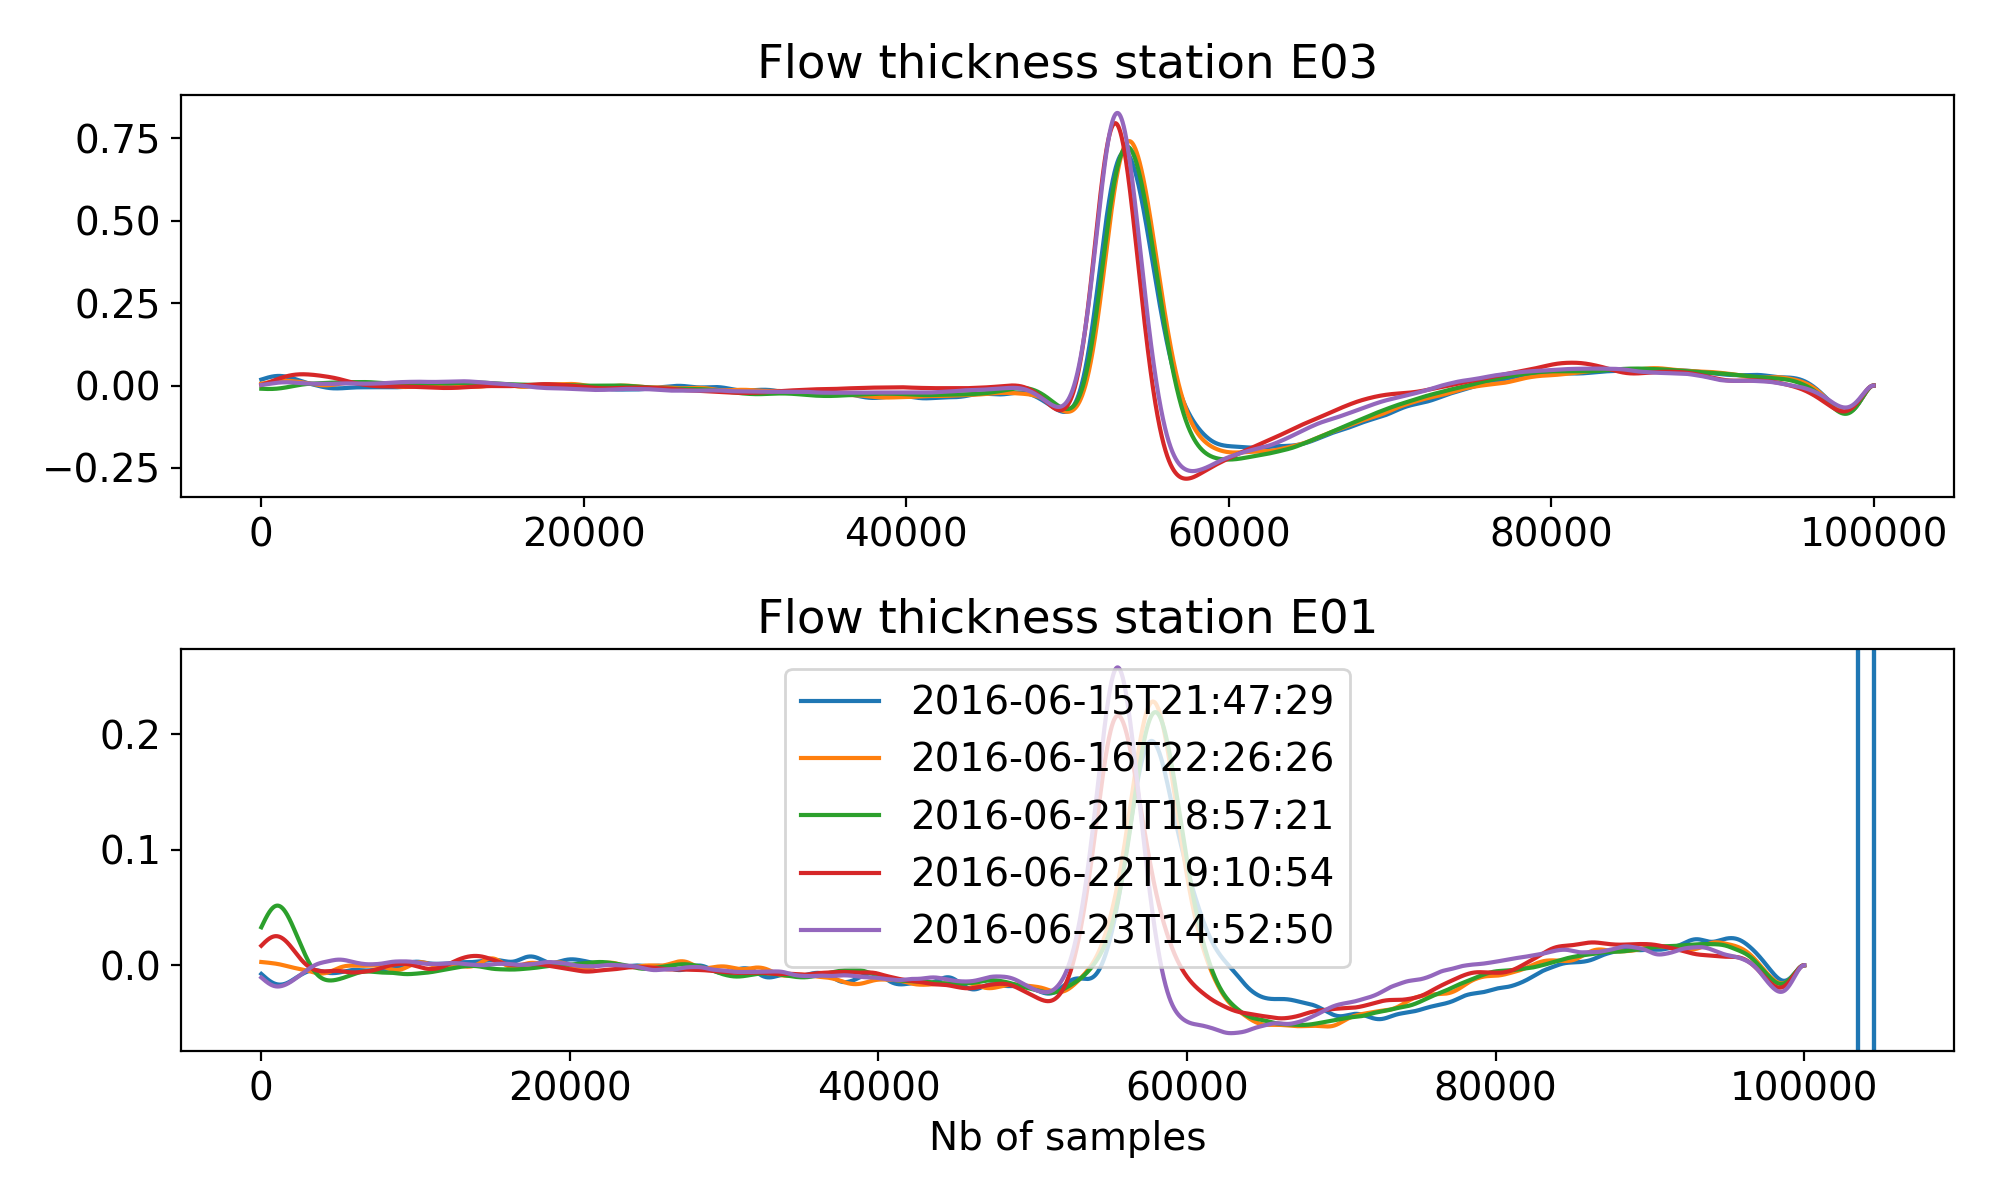

Unnamed: 0  year  julday                 time  max_tilt  tilt0  tilt1  \
0          22  2016     166  2016-06-14T21:53:58       0.0    NaN    NaN   
1          23  2016     167  2016-06-15T21:47:29       0.0    NaN    NaN   
2          24  2016     168  2016-06-16T22:26:26       0.0    NaN    NaN   
3          25  2016     173  2016-06-21T18:57:21       0.0    NaN    NaN   
4          26  2016     174  2016-06-22T19:10:54       0.0    NaN    NaN   
5          27  2016     175  2016-06-23T14:52:50       0.0    NaN    NaN   

   tilt2  h99 location  ...  nstress_E03  thickness_E03  max_tilt_E03  \
0    NaN  0.0     USGS  ...     1.636420       0.132700      0.628363   
1    NaN  0.0     USGS  ...     2.152058       0.143416      0.708910   
2    NaN  0.0     USGS  ...     2.030125       0.150642      0.741659   
3    NaN  0.0     USGS  ...     2.216257       0.138438      0.724620   
4    NaN  0.0     USGS  ...     2.204276       0.168877      0.796218   
5    NaN  0.0     USGS  ...     2.284474       0.173408      0.827161   

   max_slope_E03 nstress_E01  thickness_E01  max_tilt_E01  max_slope_E01  \
0       0.000355    0.892225       0.081000      0.092666       0.000015   
1       0.000390    2.446350       0.138371      0.194270       0.000087   
2       0.000369    3.289877       0.190546      0.228358       0.000093   
3       0.000379    2.980363       0.169575      0.219204       0.000092   
4       0.000459    1.735964       0.147461      0.216217       0.000102   
5       0.000447    2.407821       0.151429      0.257938       0.000119   

   velocity_E03  velocity_E01  
0          8.14          4.57  
1         10.81          1.75  
2          8.92          3.16  
3          9.66          3.08  
4         11.54          6.78  
5         11.13          5.97  

[6 rows x 34 columns]

In [26]:
# Parameters to change
loc = "USGS"

# Filter DataFrame
df = info[info['location'] == loc]
df1 = df[df.year == 2016]
df1 = df1.reset_index(drop=True)

# Distance along channel of station E03 and E01
dist = ['31.7m', '65.4m']
stations = ['E03', 'E01']

plt.figure(figsize=(10,6))
si = 1
for d,s in zip(dist, stations):
    plt.subplot(2,1,si)
    ns = []
    th = []
    max_tilt = []
    max_slope = []
    for date in df1.time:
        tUTC = obspy.UTCDateTime(date)
        force_plate = pd.read_csv(f'../data/USGS_force_plate_data/2016-06-{date[8:10]}_archive.csv', encoding="ISO-8859-1")
        til = obspy.read(f'../data/USGS_tilt_data/USGS_{s}_{tUTC.date}*.mseed', format = "MSEED")
        fp_nstress = moving_average(force_plate[f'Nstress_{d}(kPa)'], 1000)
        fp_thick = moving_average(force_plate[f'Thickness_{d}(m)'], 1000)
        if date[8:10] == '14':
            if s == 'E03':
                th.append(0.1327)

            elif s == 'E01':
                th.append(0.081)
        else:
            plt.plot(til[0].data, label=date)
            th.append(max(fp_thick))
        ns.append(max(fp_nstress))        
        max_tilt.append(max(til[0].data))
        if s == 'E03':    
            max_slope.append(np.max(np.diff(til[0].data[51500:52000])))
        elif s == 'E01':
            if date[:10] == '2016-06-22' or date[:10] == '2016-06-23':
                max_slope.append(np.max(np.diff(til[0].data[53500:55000])) )
                plt.axvline(103500)
                plt.axvline(104500)
            else:
                max_slope.append(np.max(np.diff(til[0].data[56000:57000])) )
                
    plt.title(f'Flow thickness station {s}')
    df1[f'nstress_{s}'] = ns
    df1[f'thickness_{s}'] = th
    df1[f'max_tilt_{s}'] = max_tilt
    df1[f'max_slope_{s}'] = max_slope
    si += 1
plt.legend()
plt.xlabel('Nb of samples')
plt.tight_layout()
velocities_e03 = {'2016-06-14':8.14,'2016-06-15':10.81, '2016-06-16':8.92,'2016-06-21':9.66,'2016-06-22':11.54,'2016-06-23':11.13}
velocities_e01 = {'2016-06-14':4.57,'2016-06-15':1.75, '2016-06-16':3.16,'2016-06-21':3.08,'2016-06-22':6.78,'2016-06-23':5.97}
df1['velocity_E03'] = velocities_e03.values()
df1['velocity_E01'] = velocities_e01.values()
df1

<IPython.core.display.Javascript object>


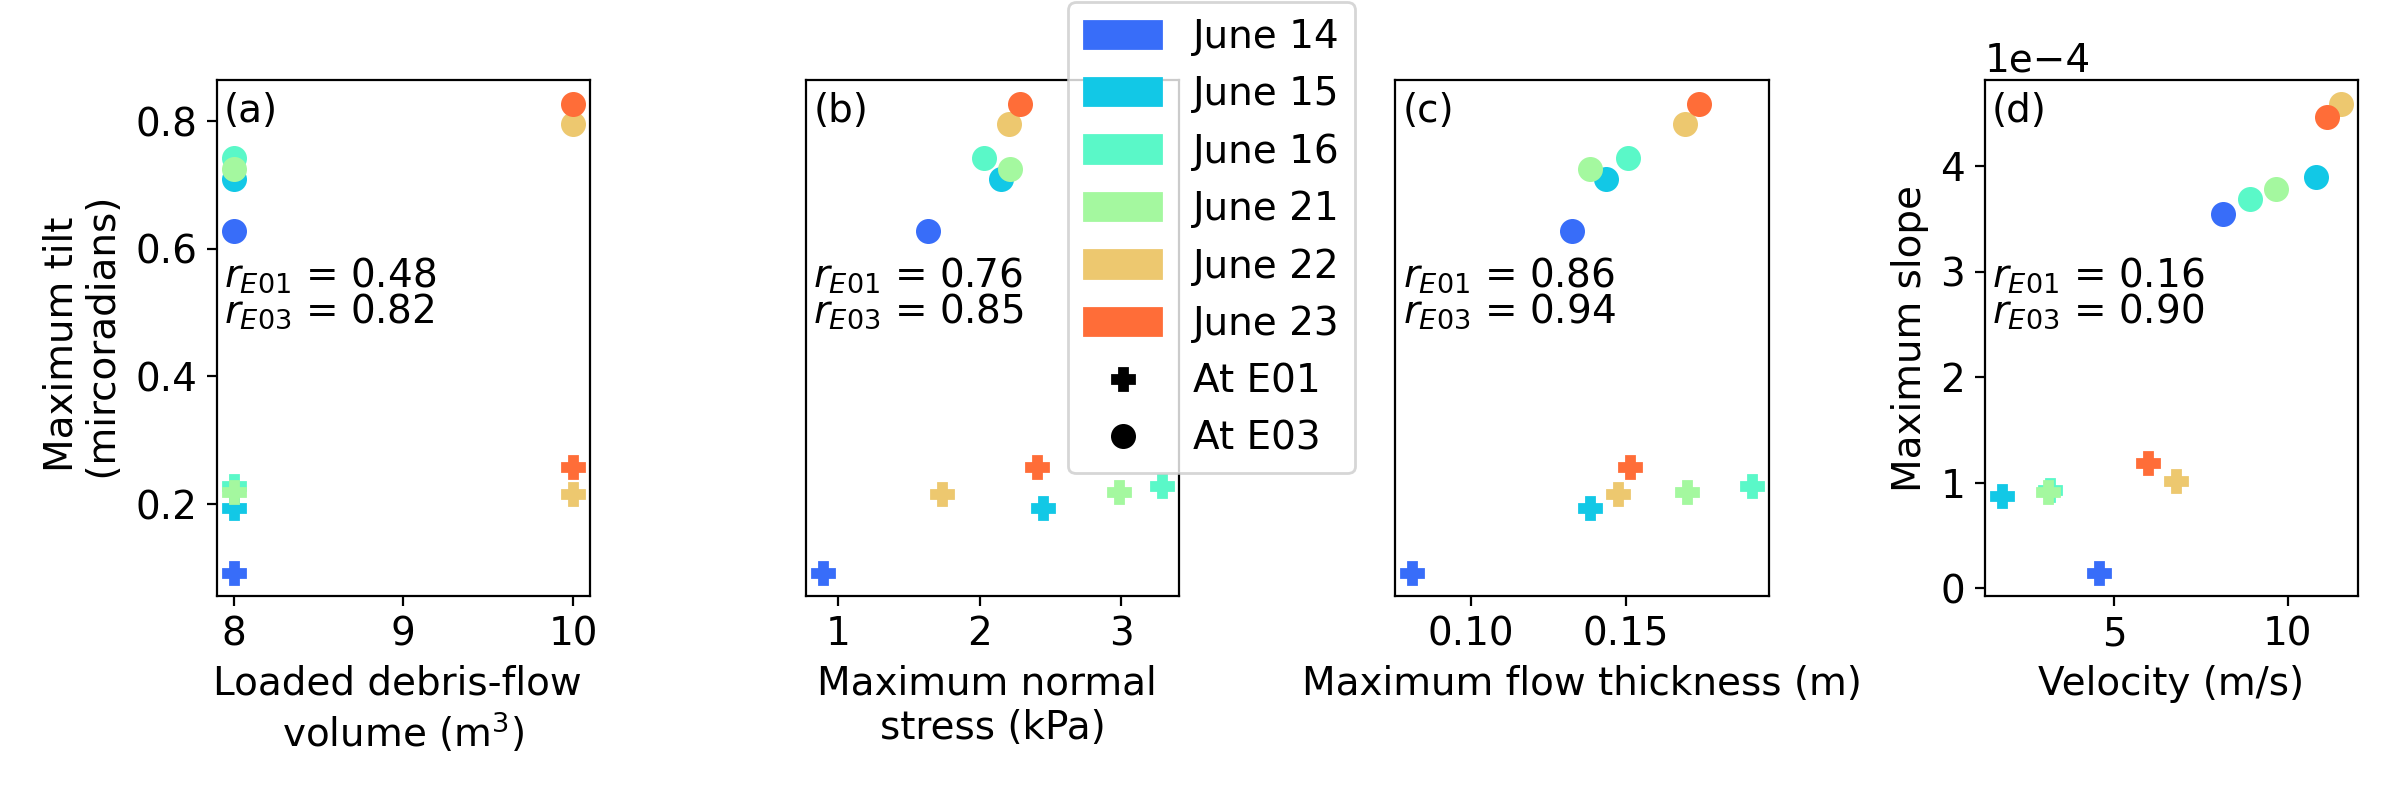

/Users/michiwen/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


In [28]:
from matplotlib.patches import Patch
import scipy
colors = sns.color_palette('rainbow', len(df1))
fig, axs = plt.subplots(1, 4, sharey=False, figsize=(12,4))

pears03 = [scipy.stats.pearsonr(df1.volume, df1.max_tilt_E03), \
         scipy.stats.pearsonr(df1.nstress_E03, df1.max_tilt_E03),scipy.stats.pearsonr(df1.thickness_E03, df1.max_tilt_E03),scipy.stats.pearsonr(df1.velocity_E03, df1.max_slope_E03)]
pears01 = [scipy.stats.pearsonr(df1.volume, df1.max_tilt_E01), \
         scipy.stats.pearsonr(df1.nstress_E01, df1.max_tilt_E01),scipy.stats.pearsonr(df1.thickness_E01, df1.max_tilt_E01),scipy.stats.pearsonr(df1.velocity_E01, df1.max_slope_E01)]
legend_elements = []
ax3 = axs[0]
ax4 = axs[1]
ax5 = axs[2]
ax6 = axs[3]
for idx, row in df1.iterrows():
    co = colors[idx]
    #if idx != 0:
    ax5.plot(row.thickness_E03, row.max_tilt_E03, 'o', color=co, markersize=8)
    ax5.plot(row.thickness_E01, row.max_tilt_E01, 'P', color=co, markersize=8)
    ax3.plot(row.volume, row.max_tilt_E03, 'o', color=co, markersize=8, label=row.time[:10])
    ax3.plot(row.volume, row.max_tilt_E01, 'P', color=co, markersize=8)
    ax4.plot(row.nstress_E03, row.max_tilt_E03, 'o', color=co, markersize=8)
    ax4.plot(row.nstress_E01, row.max_tilt_E01, 'P', color=co, markersize=8)
    legend_elements.append(Patch([0], [0], color=co, label=f"June {row.time[8:10]}"))
    ax6.plot(row.velocity_E03, row.max_slope_E03, 'o', color=co, markersize=8)
    ax6.plot(row.velocity_E01, row.max_slope_E01, 'P', color=co, markersize=8)
    
ax3.set_xlabel('Loaded debris-flow \nvolume (m$^3$)')
ax4.set_xlabel('Maximum normal \nstress (kPa)')
ax5.set_xlabel('Maximum flow thickness (m)')
ax3.set_ylabel('Maximum tilt \n (mircoradians) ')
ax6.set_xlabel('Velocity (m/s)')
ax6.set_ylabel('Maximum slope')
ax4.yaxis.set_visible(False)
ax5.yaxis.set_visible(False)

ax6.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#ax3.legend(loc='lower left', bbox_to_anchor=(0.2, 0.05))
#ax0.text(8,1.1,'(a)')
#ax0.text(8,0.9,'Correlation at E01: 0.9')
legend_elements = legend_elements + [Line2D([], [], marker='P', linestyle="None", color='k',  markersize=8, label=f"At E01"),
                   Line2D([], [], marker='o',color='k',linestyle="None", markersize=8, label=f"At E03")]
ax4.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(0.65, 0.20))
annot = ['(a)','(b)','(c)', '(d)']
axes = (ax3, ax4, ax5,ax6)
for ax, an, cor1, cor3 in zip(axes,annot, pears01, pears03):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.08*(ylim[1] - ylim[0]), an)
    ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.4*(ylim[1] - ylim[0]), '$r_{E01}$' + f' = {cor1[0]:.2f}')
    ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.47*(ylim[1] - ylim[0]), '$r_{E03}$' + f' = {cor3[0]:.2f}')
plt.tight_layout()


## Illgraben

In [29]:
import scipy

# Reading in file with information on max tilt etc.
# Values partly automatically filled in, partly manually included due to long period noise
df = pd.read_csv('../data/00_DF_characteristics_all_final.csv')

df1 = df.copy().drop(index=13)
df1 = df1.drop(index=7)
df1 = df1.reset_index(drop=True)
df

Event start       Event end  Front velocity CD 28-29 (m/s)  \
0   10.06.19 19:40  10.06.19 21:22                           0.90   
1   10.06.19 23:21  11.06.19 01:20                           2.50   
2   21.06.19 21:44  22.06.19 00:08                           6.60   
3   02.07.19 01:26  02.07.19 03:14                           3.90   
4   03.07.19 00:50  03.07.19 02:39                           0.80   
5   15.07.19 06:28  15.07.19 07:05                           3.40   
6   26.07.19 19:46  26.07.19 21:01                           8.70   
7   11.08.19 19:07  11.08.19 21:07                           7.00   
8   20.08.19 19:03  20.08.19 20:27                           0.90   
9   04.06.20 17:18  04.06.20 19:15                           3.40   
10  08.06.20 20:11  08.06.20 21:19                           3.40   
11  17.06.20 02:57  17.06.20 02:57                           2.00   
12  29.06.20 07:36  29.06.20 08:38                           1.23   
13  17.08.20 01:16  17.08.20 02:08                           0.49   
14  30.08.20 08:03  30.08.20 13:58                           0.73   

    Front velocity CD 27-28 (m/s)  Front velocity CD 27-29 (m/s)  \
0                            7.50                           2.30   
1                            2.58                           2.55   
2                            5.32                           5.65   
3                            2.84                           3.09   
4                             NaN                           2.55   
5                             NaN                            NaN   
6                            1.70                           2.23   
7                            5.20                           5.58   
8                             NaN                           3.05   
9                            1.90                           2.18   
10                            NaN                          14.22   
11                            NaN                            NaN   
12                           0.60                           0.71   
13                            NaN                           2.31   
14                            NaN                           2.47   

    Front depth laser (m)  Max flow depth laser (m)  \
0                    0.77                  0.773820   
1                    0.42                  0.782084   
2                    2.59                  3.130178   
3                    0.77                  1.746908   
4                    0.77                  0.770849   
5                    0.54                  0.712460   
6                    1.05                  1.394212   
7                    1.80                  1.806161   
8                    0.44                  1.131898   
9                    0.58                  1.730631   
10                   0.36                  0.449135   
11                   0.81                  0.812989   
12                   1.23                  1.226918   
13                   0.27                  0.641415   
14                   0.98                  1.957212   

    99th percentile flow depth laser (m)  Front depth radar (m)  \
0                               0.621513                   0.70   
1                               0.597050                   0.41   
2                               2.437405                   2.69   
3                               1.600467                   0.91   
4                               0.707153                   0.90   
5                               0.675785                   0.56   
6                               1.202059                   1.07   
7                               1.699208                   1.89   
8                               0.882591                   0.45   
9                               1.454488                   0.68   
10                              0.372220                   0.32   
11                              0.765082                   0.89   
12                              1.042188                   1.

<IPython.core.display.Javascript object>


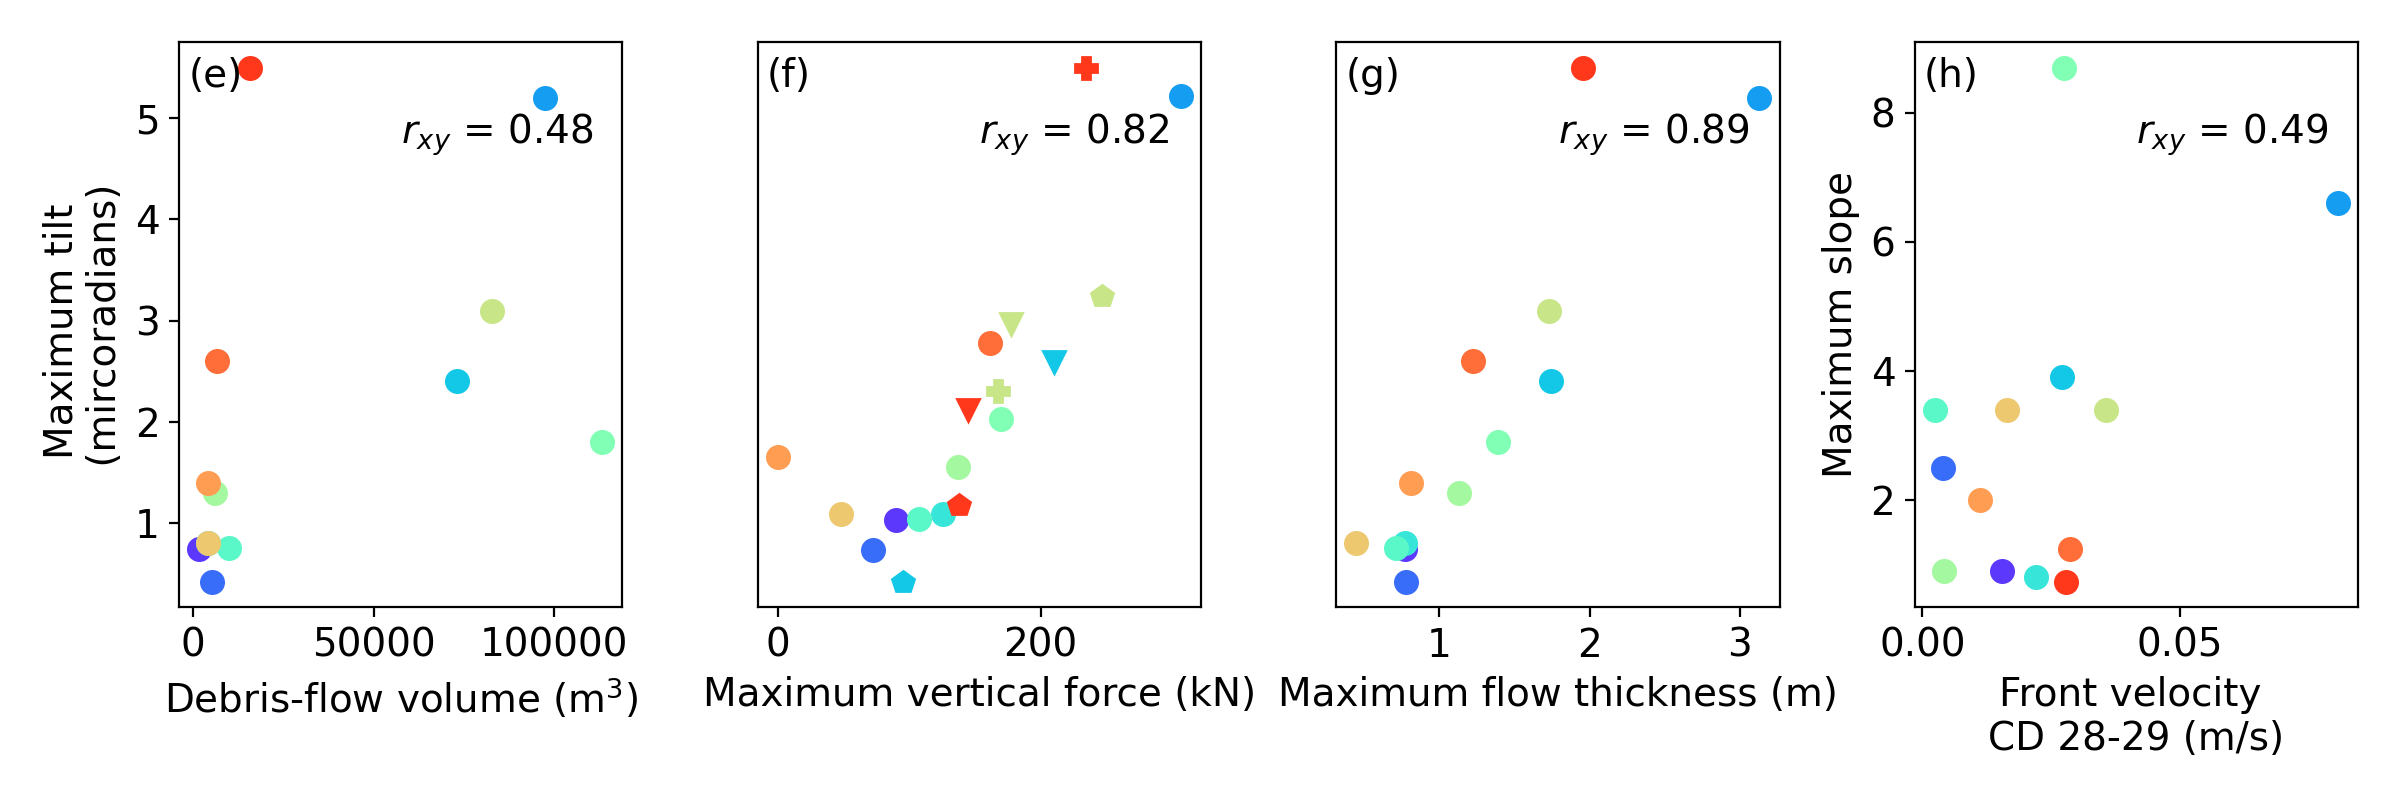

In [31]:
import seaborn as sns
colors = sns.color_palette('rainbow', len(df1))
fig, axs = plt.subplots(1, 4, figsize=(12,4))
method = 'laser'
part = '28-29'
pears = [scipy.stats.pearsonr(df1[f'Volume {method} CD {part} (m^3)'], df1.max_tilt), \
         scipy.stats.pearsonr(df1.max_forces, df1.max_tilt),scipy.stats.pearsonr(df1[f'Max flow depth laser (m)'], df1.max_tilt), \
        scipy.stats.pearsonr(df1['Front velocity CD 28-29 (m/s)'],df1.max_slope)]

ax3 = axs[0]
ax4 = axs[1]
ax5 = axs[2]
ax6 = axs[3]

for idx, row in df1.iterrows():
    co = colors[idx]
    if row.surge0 != 0:
        ax4.plot(row.surge0, row.tilt0, 'v', color=co, markersize=8, label=row.time[:10])
        if row.surge1 != 0:
            ax4.plot(row.surge1, row.tilt1, 'p', color=co, markersize=8, label=row.time[:10])
            if row.surge2 !=0:
                ax4.plot(row.surge2, row.tilt2, 'P', color=co, markersize=8, label=row.time[:10])
    else:
        ax4.plot(row.max_forces, row.max_tilt, 'o', color=co, markersize=8, label=row.time[:10])
    
    
    ax5.plot(row[f'Max flow depth laser (m)'], row.max_tilt, 'o', color=co, markersize=8)    
    ax3.plot(row[f'Volume {method} CD {part} (m^3)'], row.max_tilt, 'o', color=co, markersize=8, label=row.time[:10])
    
    ax6.plot(row.max_slope,row[f'Front velocity CD {part} (m/s)'], 'o', color=co, markersize=8, label=row.time[:10])
ax3.set_xlabel('Debris-flow volume (m$^3$)')
ax4.set_xlabel('Maximum vertical force (kN)')
ax5.set_xlabel('Maximum flow thickness (m)')
ax3.set_ylabel('Maximum tilt \n (mircoradians) ')
ax4.yaxis.set_visible(False)
ax5.yaxis.set_visible(False)
#ax5.legend(loc='upper right', bbox_to_anchor=(1, 1))
#ax0.text(8,1.1,'(a)')
#ax0.text(8,0.9,'Correlation at E01: 0.9')
annot = ['(e)','(f)','(g)', '(h)']
axes = (ax3, ax4, ax5, ax6)
for ax, an, cor in zip(axes,annot, pears):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.08*(ylim[1] - ylim[0]), an)
    ax.text(xlim[0] + 0.5*(xlim[1] - xlim[0]), ylim[1] - 0.18*(ylim[1] - ylim[0]), '$r_{xy}$' + f' = {cor[0]:.2f}')
    
ax6.set_xlabel('Front velocity \nCD 28-29 (m/s)')
ax6.set_ylabel('Maximum slope')
plt.tight_layout()
